# Estimated magnetic moment distribution

### Brief description

This Jupyter notebook is a supplementary material contaning the code needed to generate part of the synthetic data and reproduce part of the figures and results of this manuscript. This code uses the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://www.fatiando.org/index.html).

This code estimates the estimated magnetic moment distribution within a planar equivalent layer by solving a linear inverse problem. In this test, the equivalent sources have the same magnetization direction as the simulated prisms. The estimated equivalent layer is saved as a pickle file in `results`. 

**Note:** A Jupyter notebook is a document that incorporates text, results, figures, and the Python source code to produce them. If you are viewing this from the URL https://nbviewer.jupyter.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install all the required dependencies. For installing the Fatiando a Terra and all the required dependencies, please follow the instructions shown in http://www.fatiando.org/install.html.

### Import the required dependencies

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cPickle as pickle
import datetime
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st

from __future__ import division
from future.builtins import super

import auxiliary_functions as af

from fatiando import gridder
from fatiando.mesher import Prism, PointGrid
from fatiando.gridder import regular

#from fatiando.gravmag import prism, sphere
from fatiando.gravmag import _prism_numpy as prism
from fatiando.gravmag import _sphere_numpy as sphere

#from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.gravmag._eqlayer_numpy import EQLTotalField

from fatiando.inversion.regularization import Damping, Smoothness2D
from fatiando.inversion.hyper_param import LCurve
from fatiando.vis import mpl, myv
from fatiando.utils import ang2vec, vec2ang
from fatiando.constants import G, SI2MGAL

In [2]:
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['xtick.major.pad'] = 3
plt.rcParams['ytick.major.pad'] = 3

In [3]:
notebook_name = 'estimated_moment.ipynb'

In [4]:
saved_files = [] #list of saved files

### Load the synthetic model formed by two rectangular prisms

In [5]:
with open('results\\model.pickle') as f:
        full_model = pickle.load(f)

In [6]:
inc, dec = full_model['geomag_field']

In [7]:
ints, incs, decs = vec2ang(full_model['model'][0].props['magnetization'])

In [8]:
rhos = full_model['model'][0].props['density']

In [9]:
with open('results\\model_pole.pickle') as f:
        full_model_pole = pickle.load(f)

### Load the grid of points

In [10]:
with open('results\\coarse_grid.pickle') as f:
        coarse_grid = pickle.load(f)

In [11]:
coarse_grid

{'DS': 113622.01742204267,
 'N': 8100,
 'area': [0, 30000, 5000, 35000],
 'metadata': 'Generated by computation_points.ipynb on 24 October 2016 01:15:22 UTC',
 'shape': (90, 90),
 'spacing': [337.07865168539325, 337.07865168539325]}

### Load the theoretical magnetic-moment distribution

In [12]:
with open('results\\theoretical_mag_dist.pickle') as f:
        theoretical_mag_dist = pickle.load(f)

In [13]:
print theoretical_mag_dist['metadata']

Generated by theoretical_moment.ipynb on 24 October 2016 01:23:30 UTC


### Define the coordinates on the observation surface

In [14]:
#coordinates x and y of the data
xp, yp = regular(coarse_grid['area'], coarse_grid['shape'])

#vertical coordinates of the data
zp = af.observation_surface(xp,yp)

### Observed total-field anomaly

Noise-free total-field anomaly (equation 8) produced by the synthetic prisms (Figure 3) at the `coarse_grid` points on the undulating surface (Figure 4).

In [15]:
tf = prism.tf(xp,yp,zp,full_model['model'], inc, dec)

### True RTP anomaly

Noise-free RTP anomaly (equation 9) produced by the synthetic prisms (Figure 3) at the `coarse_grid` points on the undulating surface (Figure 4).

In [16]:
tf_pole = prism.tf(xp,yp,zp,full_model_pole['model'], 90., 0.)

### Planar equivalent layer

#### Parameters defining the equivalent layer

In [17]:
#horizontal plane containing the equivalent sources
z0 = np.zeros_like(zp)
#h = np.max(zp) + 1.4*dx
h = -200.
z0 += h

In [18]:
print h

-200.0


#### Estimated magnetic moment distribution

Linear inverse problem for estimating the physical property distribution within the equivalent layer. A previously estimated equivalent layer may be saved at the directory `results` as a pickle file named `inversion_notebookname.pickle`. Execute the cell below to check if this file exists. If this file does not exist, an IOError will be raised. In this case, you will need to run the inversion. To do this, you need first transform the following 17 cells from `Raw NBConvert` to `Code` and then execute them.

In [19]:
file_name = 'results\\inversion_%s.pickle' % notebook_name[:st.index(notebook_name,'.')]
with open(file_name) as f:
        inversion = pickle.load(f)

layer = inversion['layer']
predicted = inversion['predicted']
estimate = inversion['estimate']

print inversion['metadata']

Generated by estimated_moment.ipynb on 25 May 2016 21:27:21 UTC


In [20]:
difference = (10.**-9)*(estimate - theoretical_mag_dist['moment'])

In [21]:
print 'minimum, mean, maximum differences'
print '%.5f, %.5f, %.5f' % (np.min(difference), np.mean(difference), np.max(difference))

minimum, mean, maximum differences
-0.05124, -0.00116, 0.06059


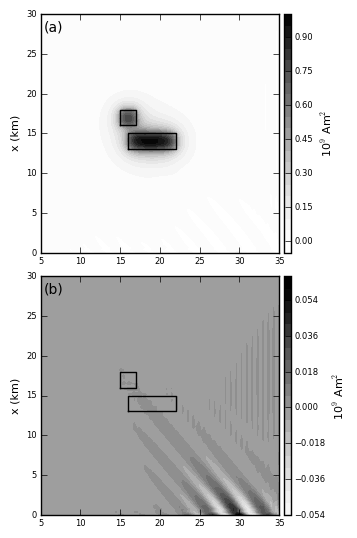

In [22]:
file_name = 'figs\\Fig7'

nplots = 2

f, (ax1, ax2) = plt.subplots(nplots,figsize=(3.33333,nplots*2.66667))

af.multiplotmap(ax1, xp, yp, (10.**-9)*estimate, coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys', prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], unit = '10$^{9}$ Am$^{2}$', 
                ranges = (0., 1.),
                figure_label = '(a)', label_x = False)

af.multiplotmap(ax2, xp, yp, difference, 
                coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys', prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], unit = '10$^{9}$ Am$^{2}$',
                ranges = (-0.06, 0.06),
                figure_label = '(b)', label_x = False)

plt.savefig(file_name+'.png', dpi=600)
saved_files.append(file_name+'.png')

plt.show()

In [23]:
caption = "(a) Estimated magnetic-moment distribution within the planar equivalent \
layer. The estimate was obtained by \
solving a linear inverse problem subject to fitting the noise-free total-field \
anomaly shown in Figure 5a. \
The equivalent sources have the same magnetization \
direction as the simulated prisms (Figure 3). \
(b) Difference between the estimated magnetic-moment \
distribution (Figure 7a) and the \
theoretical-magnetic moment distribution \
(Figure 6a). \
The black rectangles represent the horizontal projection of \
the simulated prisms (Figure 3)."

In [24]:
dp(md(caption))

(a) Estimated magnetic-moment distribution within the planar equivalent layer. The estimate was obtained by solving a linear inverse problem subject to fitting the noise-free total-field anomaly shown in Figure 5a. The equivalent sources have the same magnetization direction as the simulated prisms (Figure 3). (b) Difference between the estimated magnetic-moment distribution (Figure 7a) and the theoretical-magnetic moment distribution (Figure 6a). The black rectangles represent the horizontal projection of the simulated prisms (Figure 3).

#### Save the results

Save the results as a pickle file named `inversion_notebookname.pickle` at the directory `results`.

#### Data fit

#### Comparison between the true and predicted RTP data

In [25]:
# equivalent layer
layer_pole = PointGrid(coarse_grid['area'], h, coarse_grid['shape'])

In [26]:
# set the magnetic moment distribution within the planar equivalent layer
# for calculating the RTP anomaly
layer_pole.addprop('magnetization', ang2vec(estimate, 90., 0.))

In [27]:
# predicted RTP anomaly
tf_pred_pole = sphere.tf(xp, yp, zp, layer_pole, 90., 0.)

In [28]:
print 'minimum, mean and maximum differences'
print 'Total-field anomalies:'
print '%.5f %.5f %.5f' % (np.min(predicted - tf), np.mean(predicted - tf), np.max(predicted - tf))
print 'RTP anomalies:'
print '%.5f %.5f %.5f' % (np.min(tf_pred_pole - tf_pole), np.mean(tf_pred_pole - tf_pole), np.max(tf_pred_pole - tf_pole))

minimum, mean and maximum differences
Total-field anomalies:
-0.01323 0.00001 0.02179
RTP anomalies:
-210.64542 -0.19794 226.83889


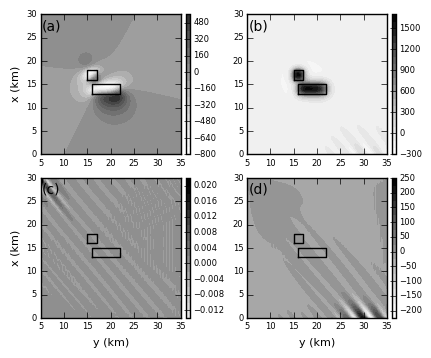

In [29]:
file_name = 'figs\\Fig8'

f, ax = plt.subplots(2,2,figsize=(4.33333,1.33333*2.66667))

af.multiplotmap(ax[0][0], xp, yp, predicted, coarse_grid['shape'], coarse_grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = af.scale_bounds(tf, div=True),
                figure_label = '(a)', label_position = (0.02,0.89), label_x = False)

af.multiplotmap(ax[1][0], xp, yp, predicted - tf, coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = (-0.02, 0.02),
                figure_label = '(c)', label_position = (0.02,0.89))

af.multiplotmap(ax[0][1], xp, yp, tf_pred_pole, coarse_grid['shape'], coarse_grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model_pole['projection'],
                figure_label = '(b)', label_position = (0.02,0.89), label_x = False, label_y = False)

af.multiplotmap(ax[1][1], xp, yp, tf_pred_pole - tf_pole, coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], 
                figure_label = '(d)', label_position = (0.02,0.89), label_y = False)

plt.tight_layout()

plt.savefig(file_name+'.png', dpi=600)
saved_files.append(file_name+'.png')

plt.show()

In [30]:
caption = "(a) Total-field and (b) RTP anomalies produced by the planar \
equivalent layer whose estimated magnetic moment distribution \
is shown in Figure 7a. \
(c) Difference between the total-field anomalies shown in a and \
Figure 5a. (d) Difference between the RTP anomalies shown in b and Figure \
5b. These anomalies were calculated at a regular grid of \
%d $\\times$ %d points located on the undulating surface \
(Figure 4). The black rectangles represent \
the horizontal projection of the simulated prisms \
(Figure 3). The field values are in nT." \
% (coarse_grid['shape'][0], coarse_grid['shape'][1])

In [31]:
dp(md(caption))

(a) Total-field and (b) RTP anomalies produced by the planar equivalent layer whose estimated magnetic moment distribution is shown in Figure 7a. (c) Difference between the total-field anomalies shown in a and Figure 5a. (d) Difference between the RTP anomalies shown in b and Figure 5b. These anomalies were calculated at a regular grid of 90 $\times$ 90 points located on the undulating surface (Figure 4). The black rectangles represent the horizontal projection of the simulated prisms (Figure 3). The field values are in nT.

### Saved files

In [32]:
with open('reports\\report_%s.md' % notebook_name[:st.index(notebook_name,'.')], 'w') as f:
    f.write('# Saved files \n')
    f.write('\n\n'+inversion['metadata']+'\n\n')
    f.write('*  `results\\inversion_%s.pickle`' % notebook_name[:st.index(notebook_name,'.')])
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)
    f.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        f.write('*  `%s` \n' % (sf))

1  figs\Fig7.png
2  figs\Fig8.png
